# Factors Affecting AirBNB Price in NYC

## Preparation

In [1]:
# import packages
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from math import sqrt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import names 
from nltk import NaiveBayesClassifier as NBC
import requests
import re
import random

sia = SentimentIntensityAnalyzer()

In [2]:
# import dataset
data_raw = pd.read_csv("AB_NYC_2019.csv")
data_raw

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [3]:
# We first perform a gender identification training.
def gender_features(word):
    if len(word)==0:
        return {'lastletter': "x"}
    return {'lastletter': word[-1]}

maleNames = [(name, 'male') for name in names.words('male.txt')]
femaleNames = [(name, 'female') for name in names.words('female.txt')]
allNames = maleNames + femaleNames
random.shuffle(allNames)
featureData = [(gender_features(namelist), gender) for (namelist, gender) in allNames]
test_data = featureData[:700]
train_data = featureData[700:]
classifier = NBC.train(train_data)

# The above code is adopted from geeksforgeeks.com. 

In [4]:
# We defind a method to determine if a name belongs to a man or woman.
def get_gender(name):
    return classifier.classify(gender_features(str(name)))

In [5]:
# We run this line to see if we set empty names to male or female in the previous step:
get_gender("x")

'male'

In [6]:
# Define a function that only gets the first person's name in the host_name column.
def get_first_name(name):
    name = str(name)
    if " " in name:
        name = name.split(" ")[0]
    if "?" in name:
        name = name.split("?")[0]
    if "+" in name:
        name = name.split("+")[0]
    if "And" in name:
        name = name.split("And")[0]
    if "and" in name:
        name = name.split("and")[0]
    if "-" in name:
        name = name.split("-")[0]
    if "(" in name:
        name = name.split("(")[0]
    return name

In [7]:
# Define a function for sentiment analysis of the house description:
def get_sentiment(description):
    raw = str(sia.polarity_scores(str(description)))
    a = re.sub(r".*\:", "", raw, 1)
    b = float(re.sub(r"\}", "", a))
    return b

In [8]:
# # Define a function for one-hot encoding for the five boroughs in NYC:
# def borough_one_hot(hello):
#     y = np.array(str(hello))
#     ohe = OneHotEncoder()
#     ohe.fit([["Bronx"],["Staten Island"],["Brooklyn"],["Queens"],["Manhattan"]])
#     a = (ohe.transform(y.reshape(-1,1)).toarray()[0])
#     return a

# # Define a function for one-hot encoding for the three room types in NYC:
# def room_one_hot(hello):
#     y = np.array(str(hello))
#     ohe = OneHotEncoder()
#     ohe.fit([["Private room"],["Entire home/apt"],["Shared room"]])
#     a =((ohe.transform(y.reshape(-1,1)).toarray())[0])
#     return a

# # The above code is adpoted from geeksforgeeks.com.

# Doesn't work so well for this project, but (maybe) a good reference for future projects...

***********
## Data Cleaning

In [9]:
# Clean our data by droping those houses with no reviews 
# as their prices may not fall in the range of people's expectation.
data_row = data_raw[data_raw.get("reviews_per_month")>0]

# Also we drop those houses with avaliability less than a week throughout the year
# as those people might just list their houses online for fun.
data_row = data_row[data_row.get("availability_365")>7]
data_row = data_row.assign(host_name = data_row.get("host_name").apply(get_first_name))
data_row

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48740,36413632,Spacious 2BR in Beautiful Brooklyn Heights,6608220,Matt,Brooklyn,Brooklyn Heights,40.69827,-73.99649,Entire home/apt,550,3,1,2019-07-07,1.00,1,230
48782,36425863,Lovely Privet Bedroom with Privet Restroom,83554966,Rusaa,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,1,1,2019-07-07,1.00,1,147
48790,36427429,No.2 with queen size bed,257683179,H Ai,Queens,Flushing,40.75104,-73.81459,Private room,45,1,1,2019-07-07,1.00,6,339
48799,36438336,Seas The Moment,211644523,Ben,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,1,1,2019-07-07,1.00,1,87


In [10]:
# Prepare for one-hot encoding for boroughs and room types:
Brooklyn = np.zeros(data_row.shape[0])
Manhattan = np.zeros(data_row.shape[0])
Bronx = np.zeros(data_row.shape[0])
Queens = np.zeros(data_row.shape[0])
Staten_island = np.zeros(data_row.shape[0])
private_room = np.zeros(data_row.shape[0])
entire_room = np.zeros(data_row.shape[0])
shared_room = np.zeros(data_row.shape[0])

for i in range(data_row.shape[0]):
    if data_row.get("neighbourhood_group").iloc[i] == "Brooklyn":
        Brooklyn[i] = 1
    elif data_row.get("neighbourhood_group").iloc[i] == "Manhattan":
        Manhattan[i] = 1
    elif data_row.get("neighbourhood_group").iloc[i] == "Bronx":
        Bronx[i] = 1
    elif data_row.get("neighbourhood_group").iloc[i] == "Staten Island":
        Staten_island[i] = 1
    elif data_row.get("neighbourhood_group").iloc[i] == "Queens":
        Queens[i] = 1
    if data_row.get("room_type").iloc[i] == "Private room":
        private_room[i] = 1
    elif data_row.get("room_type").iloc[i] == "Entire home/apt":
        entire_room[i] = 1
    elif data_row.get("room_type").iloc[i] == "Shared room":
        shared_room[i] = 1

In [11]:
# We only keep the the columns that could be used as the independent factor for our prediction.
data_all_empty_male = pd.DataFrame().assign(host_name = data_row.get("host_name")).assign(host_gender = data_row.get("host_name").apply(get_gender)).assign(Brooklyn = Brooklyn).assign(Manhattan = Manhattan).assign(Bronx = Bronx).assign(Staten_island = Staten_island).assign(Queens = Queens).assign(private_room = private_room).assign(entire_room = entire_room).assign(shared_room = shared_room).assign(description_score = data_row.get("name").apply(get_sentiment)).assign(minimum_nights=data_row.get("minimum_nights")).assign(availabiliy = data_row.get("availability_365")).assign(price=data_row.get("price"))
data_all_empty_male

,host_name,host_gender,Brooklyn,Manhattan,Bronx,Staten_island,Queens,private_room,entire_room,shared_room,description_score,minimum_nights,availabiliy,price
0,John,male,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.4019,1,365,149
1,Jennifer,male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,1,355,225
3,LisaRoxanne,female,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,1,194,89
5,Chris,male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,3,129,200
7,Shunichi,female,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,2,220,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48740,Matt,male,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5994,3,230,550
48782,Rusaa,female,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5859,1,147,129
48790,H Ai,female,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0000,1,339,45
48799,Ben,male,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0000,1,87,235


In [12]:
# Since we assigned those with no names to male in the last step, we drop all of them.
data_with_names = data_all_empty_male
for i in range(len(data_with_names.get("host_name"))):
    if len(data_with_names.get("host_name").iloc[i]) == 0:
        data_with_names.get("host_gender").iloc[i] = "unknown"
data_with_names

c:\users\wmy\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,host_name,host_gender,Brooklyn,Manhattan,Bronx,Staten_island,Queens,private_room,entire_room,shared_room,description_score,minimum_nights,availabiliy,price
0,John,male,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.4019,1,365,149
1,Jennifer,male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,1,355,225
3,LisaRoxanne,female,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,1,194,89
5,Chris,male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,3,129,200
7,Shunichi,female,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,2,220,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48740,Matt,male,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5994,3,230,550
48782,Rusaa,female,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5859,1,147,129
48790,H Ai,female,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0000,1,339,45
48799,Ben,male,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0000,1,87,235


**********
## Finding the Relations

### Relation between price and gender
People have been suggesting if they use a female name on AirBNB, they can actually charge more on the same house than using a male name. Let's see if this is the case in NYC.

In [13]:
data = data_with_names.drop(columns = "host_name")
data = data[(data.get("host_gender")=="male")|(data.get("host_gender")=="female")]
data

,host_gender,Brooklyn,Manhattan,Bronx,Staten_island,Queens,private_room,entire_room,shared_room,description_score,minimum_nights,availabiliy,price
0,male,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.4019,1,365,149
1,male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,1,355,225
3,female,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,1,194,89
5,male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,3,129,200
7,female,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,2,220,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48740,male,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5994,3,230,550
48782,female,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5859,1,147,129
48790,female,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0000,1,339,45
48799,male,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0000,1,87,235


In [14]:
data.groupby("host_gender").mean().get("price")

host_gender
female    147.714395
male      155.417600
Name: price, dtype: float64

In [15]:
# We run a simulation test to see if avg male price is indeed higher than avg female price.
test_stats = np.array([])
for i in np.arange(5000):
    abc = data
    abc = abc.assign(test = np.random.permutation(abc.get("price")))
    diff = abc.groupby("host_gender").mean().get("test").loc["male"] - abc.groupby("host_gender").mean().get("test").loc["female"]
    test_stats = np.append(test_stats, diff)

In [16]:
# Create a 95% confidence interval:
lower_bound = np.percentile(test_stats,2.5)
upper_bound = np.percentile(test_stats,97.5)

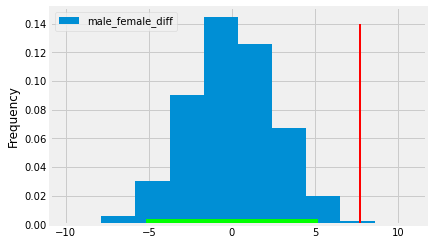

In [17]:
# Plot:
diff = data.groupby("host_gender").mean().get("price").loc["male"] - data.groupby("host_gender").mean().get("price").loc["female"]
bpd.DataFrame().assign(male_female_diff=test_stats).plot(kind='hist', density=True)
plt.plot([lower_bound, upper_bound], [0, 0],lw=10,color='lime')
plt.plot([diff, diff], [0, 0.14], lw=2, color='r');

In [18]:
p_value = np.count_nonzero(test_stats >= data.groupby("host_gender").mean().get("price").loc["male"] - data.groupby("host_gender").mean().get("price").loc["female"]) / len(test_stats)
p_value

0.0014

Since our p_value is smaller than 0.05, there is sufficient evidence that suggest the average AirBNB price set by male is higher than the average AirBNB price set by female in NYC.
### Other Factors

In [19]:
# We also need to standarlize all the independent variables for the prediction:
data_indep_stan = data.drop(columns = "host_gender")
for col in list(data_indep_stan.columns)[0:-1]:
    new = (data_indep_stan.get(col) - data_indep_stan.get(col).mean()) / np.std(data_indep_stan.get(col))
    data_indep_stan = data_indep_stan.assign(**{col : new})
data_indep_stan

,Brooklyn,Manhattan,Bronx,Staten_island,Queens,private_room,entire_room,shared_room,description_score,minimum_nights,availabiliy,price
0,1.209805,-0.832991,-0.175936,-0.109363,-0.407843,1.089319,-1.032973,-0.164854,0.632932,-0.285650,1.519203,149
1,-0.826579,1.200493,-0.175936,-0.109363,-0.407843,-0.918005,0.968080,-0.164854,-0.748573,-0.285650,1.435759,225
3,1.209805,-0.832991,-0.175936,-0.109363,-0.407843,-0.918005,0.968080,-0.164854,-0.748573,-0.285650,0.092318,89
5,-0.826579,1.200493,-0.175936,-0.109363,-0.407843,-0.918005,0.968080,-0.164854,-0.748573,-0.186085,-0.450065,200
7,-0.826579,1.200493,-0.175936,-0.109363,-0.407843,1.089319,-1.032973,-0.164854,-0.748573,-0.235867,0.309272,79
...,...,...,...,...,...,...,...,...,...,...,...,...
48740,1.209805,-0.832991,-0.175936,-0.109363,-0.407843,-0.918005,0.968080,-0.164854,1.311826,-0.186085,0.392715,550
48782,-0.826579,1.200493,-0.175936,-0.109363,-0.407843,1.089319,-1.032973,-0.164854,1.265421,-0.285650,-0.299866,129
48790,-0.826579,-0.832991,-0.175936,-0.109363,2.451922,1.089319,-1.032973,-0.164854,-0.748573,-0.285650,1.302249,45
48799,-0.826579,-0.832991,-0.175936,9.143879,-0.407843,1.089319,-1.032973,-0.164854,-0.748573,-0.285650,-0.800527,235


In [20]:
# We perform a regression to see how other facors affect the price.
df_train = data_indep_stan
features = list(data_indep_stan.columns[1:-1])
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
y_intercept = linreg.intercept_

# The above code is adopted from the slides used for ML tutorial session during UCSD DataHacks 2020.

di = dict()
for i in range(len(coefficients)):
    di[list(data_indep_stan.columns)[i]] = coefficients[i]
di

{'Brooklyn': 29.481150611752273,
 'Manhattan': -6.03486871611717,
 'Bronx': -4.970094133852549,
 'Staten_island': -7.574667704964369,
 'Queens': 15570796975506.26,
 'private_room': 15619595444370.256,
 'entire_room': 5016275669570.697,
 'shared_room': -3.5472689944996914,
 'description_score': -4.544650811808186,
 'minimum_nights': 16.71499317535376}

Okay, so we are getting coefficients that **do not make sense at all**.

**:(**

*Hello, Kaggle dataset: Very disappointed at u!*

We will discuss why this happens in the *Problem* session. Right now, let's just instead focus on a single variable a time.

In [21]:
list(data_indep_stan.columns)[9]

'minimum_nights'

In [22]:
# Availabiliy:
df_train = data_indep_stan
features = ['availabiliy']
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
coefficients

array([13.26443711])

In [23]:
# Description Score:
df_train = data_indep_stan
features = ['description_score']
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
coefficients

array([-2.4188361])

In [24]:
# Minimum Nights:
df_train = data_indep_stan
features = ['minimum_nights']
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
coefficients

array([3.99196084])

In [25]:
# description_score, minimum_nights, and availabiliy:
df_train = data_indep_stan
features = list(data_indep_stan.columns[9:12])
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
y_intercept = linreg.intercept_
di = dict()
for i in range(3):
    di[list(data_indep_stan.columns)[i+8]] = coefficients[i]
di

{'description_score': 1.9554898805705474e-15,
 'minimum_nights': 5.773159728050814e-15,
 'availabiliy': 0.9999999999999992}

In [26]:
# Borough:
df_train = data_indep_stan
features = list(data_indep_stan.columns[1:6])
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
y_intercept = linreg.intercept_
di = dict()
for i in range(5):
    di[list(data_indep_stan.columns)[i]] = coefficients[i]
di

{'Brooklyn': 30.057380045013375,
 'Manhattan': -6.056478295212262,
 'Bronx': -3.6032391539564514,
 'Staten_island': -6.845939336581916,
 'Queens': -53.70673857977151}

In [27]:
# Room Type:
df_train = data_indep_stan
features = list(data_indep_stan.columns[6:9])
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
y_intercept = linreg.intercept_
di = dict()
for i in range(3):
    di[list(data_indep_stan.columns)[i+5]] = coefficients[i]
di

{'private_room': 62.76934260774249,
 'entire_room': -3.6871908140150733,
 'shared_room': -3.8355455339573377}

In [28]:
# Try combine borough and room type together:
df_train = data_indep_stan
features = list(data_indep_stan.columns[1:9])
x = df_train.loc[:, features]
y = df_train.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coefficients = linreg.coef_
y_intercept = linreg.intercept_
di = dict()
for i in range(8):
    di[list(data_indep_stan.columns)[i]] = coefficients[i]
di

{'Brooklyn': 29.67899165158433,
 'Manhattan': -5.38933352932505,
 'Bronx': -3.979703084542698,
 'Staten_island': -6.438754611714968,
 'Queens': 15068361043695.428,
 'private_room': 15115584891543.318,
 'entire_room': 4854411306159.218,
 'shared_room': -3.969859674552034}

Ugh! It seems those two factors just do not work well together when performing regression. Let's stop here and go to *Conclusion*.

****
## Conclusion
1. It seems men are more likely to set a higher price on AirBNB than women, as least in New York City.


2. We tried to see how variables like boroughs and room types impact price, but the answer we get are clearly incorrect. It seems Brooklyn is the most expensive and Queens is the cheapest, which makes some sense. Also, private room is the most expensive, and shared room is the cheapest, which is in line with our expectations.


3. It seems that price has a positive correlation with minimum_nights and availabiliy, but has a negative correlation with description score.

***********************
# Some Random Stuff
## Thoughts 
* In this project, we used basic functions of pandas along with statistic test and machine learning to see how different variables affect AirBNB price in NYC. While there are sooooo many problems listed below, I did practice various skills learned from this class, such as one-hot encoding, sentiment analysis, and text processing tools. 

## Problems with the Project


* Our methods of determining if a name belongs to a man or woman only includes checking the last letter of the name, so it is not 100% accurate. (I didn't find a better method online.) Also, some houses in our data are listed on AirBNB by agencies, but we treated them as a person as well.


* The dataset does not contain the feature "**square footage**", which may play a very important role in determining the price and explain why we are getting those riduculous coefficients. Again, very, very disappointed at you, dataset. **:(**


* The "neighbourhood" column in the original .csv file may have strong correlation with the house price, but since it is too time-consuming to implement one-hot encoding for all of them, I simply ignored that column.


* I adpoted some code from 2020 UCSD DataHacks and from online; However, I still do not understand every line of the code. For instance, in the regression session, when I changed the value of *test_size*, the coefficients also changed, but I have no idea what this variable control.


* I am still not very sure if sentiment analysis should be used in this project, as it indicate some descriptions have negative compound score, which simply do not make sense. Also, that minds us that we should doubt the accuracy of the result we are getting.


### Possible Further Approaches
* Get the square footage data and repeat what we have done above. (Unfortunately, square footage data is not made public on AirBNB)


* Focus on one borough only each time and study how other variable affect the price in this borough.


* We could also repeat why we did in the gender section, performing a ANOVA test on the mean price in different boroughs.